# Objetivo do Projeto

O principal objetivo deste projeto é <u>treinar e demonstrar o meu conhecimento sobre modelos supervisionados de classificação</u>. Por esse motivo, escolhi um conjunto de dados desbalanceados de usuários de contas bancárias de uma empresa fictícia (Top Bank) para prever a rotatividade dos clientes - Churn Prediction. Além da criação do modelo de previsão, criei um contexto e questionamentos que devem ser respondidos através da análise do conjunto de dados e do desempenho do modelo.

## Contexto:
Top Bank atua na Europa tendo como principal produto uma conta bancária. Este produto pode manter o salário do cliente e efetuar pagamentos. Essa conta não tem nenhum custo nos primeiros 12 meses, porém, após esse período, o cliente precisa recontratar o banco para os próximos 12 meses e refazer esse processo todos os anos. Recentemente, a equipe de análise notou que a taxa de churn está aumentando.
Como Cientista de Dados, você precisa criar um plano de ação para diminuir o número de clientes churn e mostrar o retorno financeiro da sua solução.
Além disso, você precisará fornecer um relatório relatando o desempenho de seu modelo e o impacto financeiro de sua solução.
Perguntas que o CEO e a equipe do Analytics gostariam de ver em seu relatório:

1. Qual é a atual taxa de churn do Top Bank?
2. Qual é o desempenho do modelo na classificação de clientes como churns?
3. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

# Importações (bibliotecas, dados e funções)

## Bibliotecas

In [1]:
import sys
sys.path.append('../..') #caminho relativo para pasta utils

In [2]:
#Data Description
import pandas as pd
import numpy as np
import utils
from scipy import stats

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preparation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

#Feature Selection
from sklearn.model_selection import train_test_split
from boruta import BorutaPy

#Machine Learning, Metrics and Hyperparameter Optimization
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, make_scorer, recall_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from skopt import dummy_minimize, gp_minimize
from skopt.plots import plot_convergence

#Parameter and Model Saving
import pickle

#Display Jupyter
from IPython.core.display import HTML
from IPython.core.display import Image
import warnings
warnings.filterwarnings('ignore')

## Funções

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## Dados

In [4]:
df = pd.read_csv('../data/churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Descrição e Manipulação de Dados

## Significado dos Dados

- **RowNumber**: o número dos registros
- **CustomerID**: identificador único de clientes
- **Surname**: sobrenome do cliente
- **CreditScore**: pontuação de crédito do cliente para o mercado financeiro (quanto maior o score, é um bom pagador)
- **Geography**: o país do cliente
- **Gender**: o gênero do cliente
- **Age**: a idade do cliente
- **Tenure**: número de anos que o cliente está no banco
- **Balance**: o valor que o cliente tem em sua conta
- **NumOfProducts**: o número de produtos que o cliente possui (no caso, contas)
- **HasCrCard**: se o cliente tiver cartão de crédito
- **IsActiveMember**: se o cliente estiver ativo (nos últimos 12 meses)
- **EstimateSalary**: estimativa de salário anual dos clientes
- **Exited**: se o cliente for churn (*variável resposta*)

## Renomeando Variáveis

In [5]:
renamed_columns = ['numero_linha', 'id_cliente', 'sobrenome', 'score_credito', 'geografia', 'genero', 'idade', 'tempo_permanencia', 
                   'saldo', 'numero_de_contas', 'tem_cartao_credito', 'membro_ativo', 'salario_estimado', 'Churn']
df.columns = renamed_columns

## Dimensão dos Dados

In [6]:
df_dimensions = df.shape
print(f'A base de dados possui {df_dimensions[0]} clientes e {df_dimensions[1]} variáveis.')

A base de dados possui 10000 clientes e 14 variáveis.


## Tipos de Dados

In [7]:
df.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito      int64
membro_ativo            int64
salario_estimado      float64
Churn                   int64
dtype: object

## Checagem de Existência de Dados Duplicados

In [8]:
df[df.duplicated(subset= ['id_cliente'])]

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn


- A base de dados não possui dados duplicados.

## Manipulação de Conflitos Gerados por Valores Faltantes e Zerados

In [9]:
utils.print_missing_values_in_dataframe(df)

O dataframe não possui valores faltantes


In [10]:
utils.print_zero_values_in_dataframe(df)

'tempo_permanencia' possui 413 registros zerados (4.13%)
'saldo' possui 3617 registros zerados (36.17%)
'tem_cartao_credito' possui 2945 registros zerados (29.45%)
'membro_ativo' possui 4849 registros zerados (48.49%)
'Churn' possui 7963 registros zerados (79.63%)


### Nota:
De fato, as variáveis **tempo_permanencia, saldo, tem_cartao_credito, membro_ativo e Churn** podem assumir valores zerados.
    
<u>Obs.</u>: Uma análise de conformidade nas variáveis zeradas poderia ser realizada se houvessem variáveis associadas para cada uma das variáveis.

## Criação de Variáveis

In [11]:
#Escala FICO: escala de qualidade do score de crédito usada nos EUA.
bins = [300, 580, 670, 740, 800, float('inf')]
labels = ['too bad', 'bad', 'good', 'very good', 'excellent']

df['escala_fico'] = pd.cut(df['score_credito'], bins=bins, labels=labels, right=False)

### Alterando os tipos das variáveis

In [12]:
# Transformando algumas variáveis de tipo "integer" em tipo "category"
integer_variables_to_category_type = ['tem_cartao_credito', 'membro_ativo', 'Churn']
df[integer_variables_to_category_type] = df[integer_variables_to_category_type].astype('category')

# Transformando o restante das variáveis de tipo "object" para tipo "category"
object_columns = df.select_dtypes(include=['object']).columns
df[object_columns] = df[object_columns].astype('category')

In [13]:
df.dtypes

numero_linha             int64
id_cliente               int64
sobrenome             category
score_credito            int64
geografia             category
genero                category
idade                    int64
tempo_permanencia        int64
saldo                  float64
numero_de_contas         int64
tem_cartao_credito    category
membro_ativo          category
salario_estimado       float64
Churn                 category
escala_fico           category
dtype: object

## Nota:
- Como não existe variável temporal, identificando o momento da extração dos dados, nasce alguns questionamentos:

	1. Qual ponto no tempo a extração de dados foi feita? Qual é a relevância desse período?

	2. Se os dados foi extraído como o resumo de 1 ano, o valor de saldo representa o valor presente na conta(s) no momento da extração, ou representa o somátorio de saldo presente na(s) conta(s) durante 1 ano, ou o valor máximo do saldo presente nesse período etc.

	3. A variável Churn significa que o cliente de fato saiu da empresa ou possui a vontade de sair. Pois se o cliente de fato saiu da empresa, existe clientes que saíram do banco, mas que ainda possuiam saldo em suas contas.

	4. O que seria de fato 'membro_ativo', clientes que fizeram transações em todos os meses do ano, ou pelo menos uma vez durante o período de extração?

    - Pra esse projeto, irei modelar sem a resposta dessas questões, embora, ter o contexto melhora o entendimento do problema e possivelmente melhores resultados na modelagem dos dados.


- Com o conhecimento prévio da base de dados, posso definir uma plano para o desenvolvimento da solução do problema de negócio:
    
    1. Qual é a atual taxa de Churn do Top Bank?
        - S: Análise Univariada da variável resposta 'Churn': plotar gráfico de barras de churns e não-churns e printar porcentagem da relação das classes;

    2. Qual é o desempenho do modelo na classificação de clientes como churns?
        - S: Criar modelo de classificação com as variáveis selecionadas por nível dependência com a variável alvo;
        
    3. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?
        - S: Com o modelo criado, é possível estimar o retorno esperado, criando casos de deduções sobre os salários de cada cliente;

In [14]:
list_unselected_vars = ['id_cliente', 'sobrenome', 'numero_linha']

unselected_vars_df = df[list_unselected_vars]
df.drop(columns= list_unselected_vars, inplace= True)

# Análise Exploratória de Dados

## Análise Univariada

### Variáveis Quantitativas

- **Variáveis qualitativas nominais**: genero, geografia, tem_cartao_credito e membro_ativo;
- **Variáveis qualitativas ordinais**: escala_fico;

In [15]:
target_var_df = df[['Churn']]

qualitative_vars_df = df.select_dtypes(include= ['category'])

#### Variável Resposta

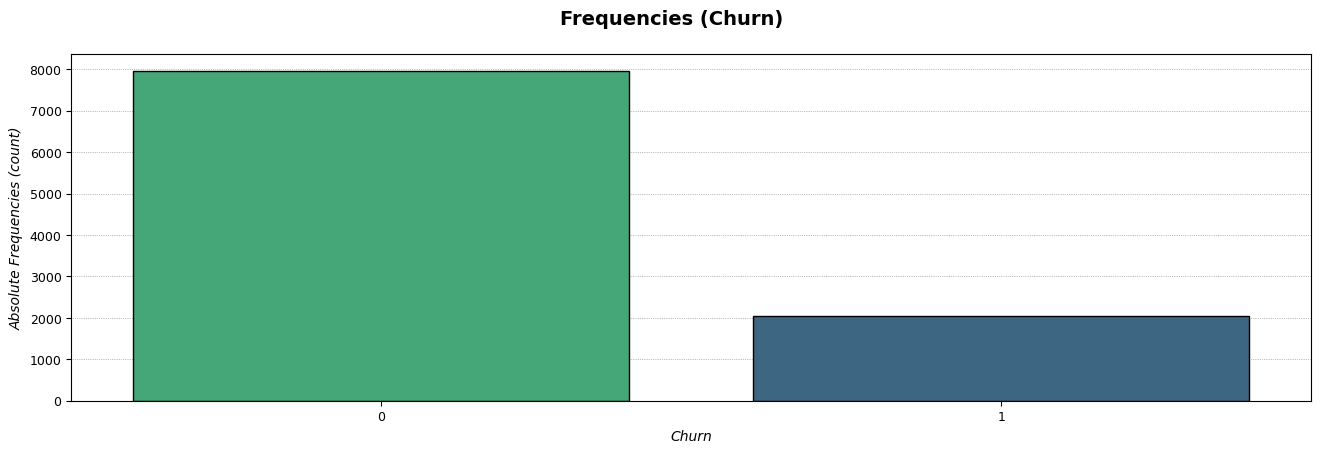

In [16]:
utils.plot_nominal_variables_distributions(target_var_df)

In [17]:
percentage_no_churn = target_var_df.value_counts()[0] / target_var_df.shape[0] * 100
percentage_yes_churn = target_var_df.value_counts()[1] / df.shape[0] * 100
print(f'Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}%  da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

Clientes que irão dar Churn correspondem a 20.37%  da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


- É evidente que a variável resposta possui classes desbalanceadas.

#### Variáveis Nominais

In [18]:
list_nominal_vars = ['genero', 'geografia', 'tem_cartao_credito', 'membro_ativo']

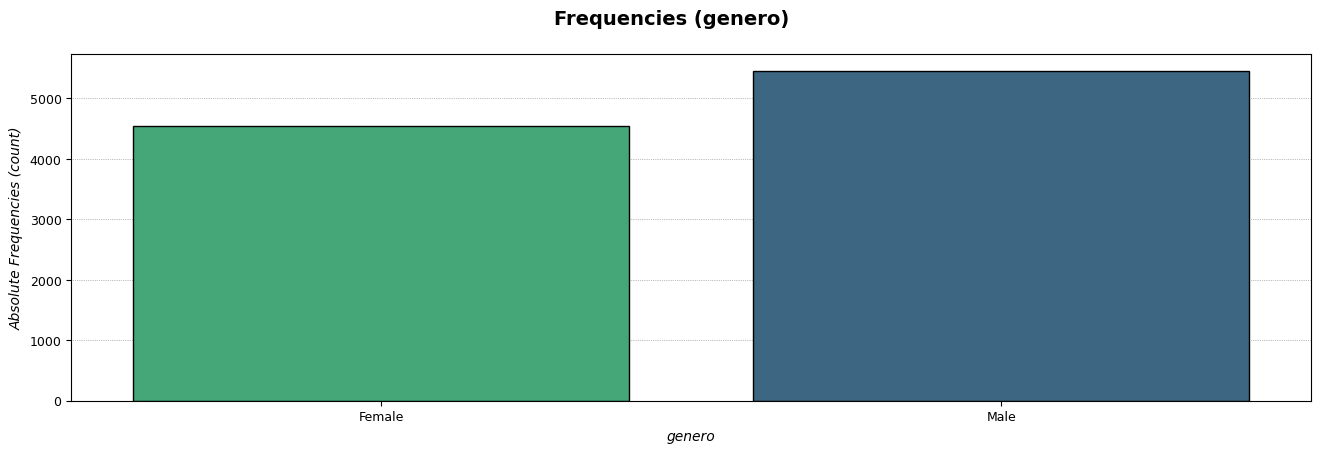

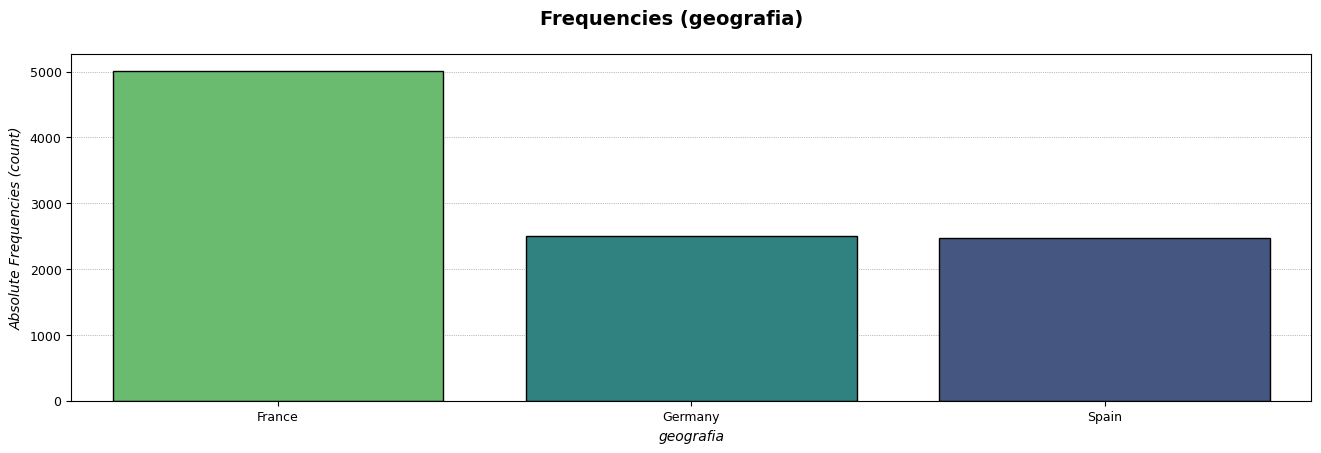

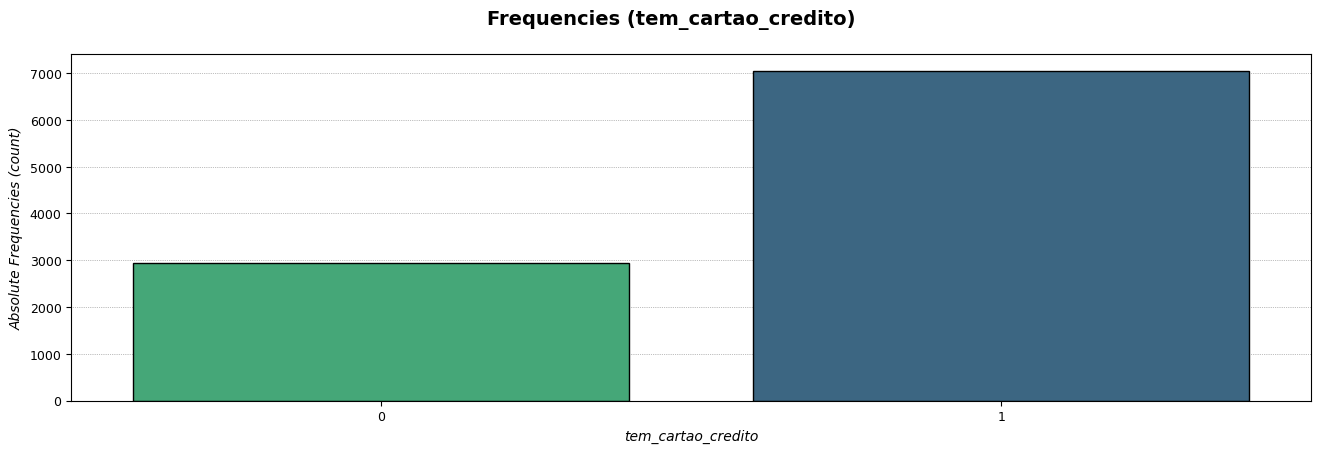

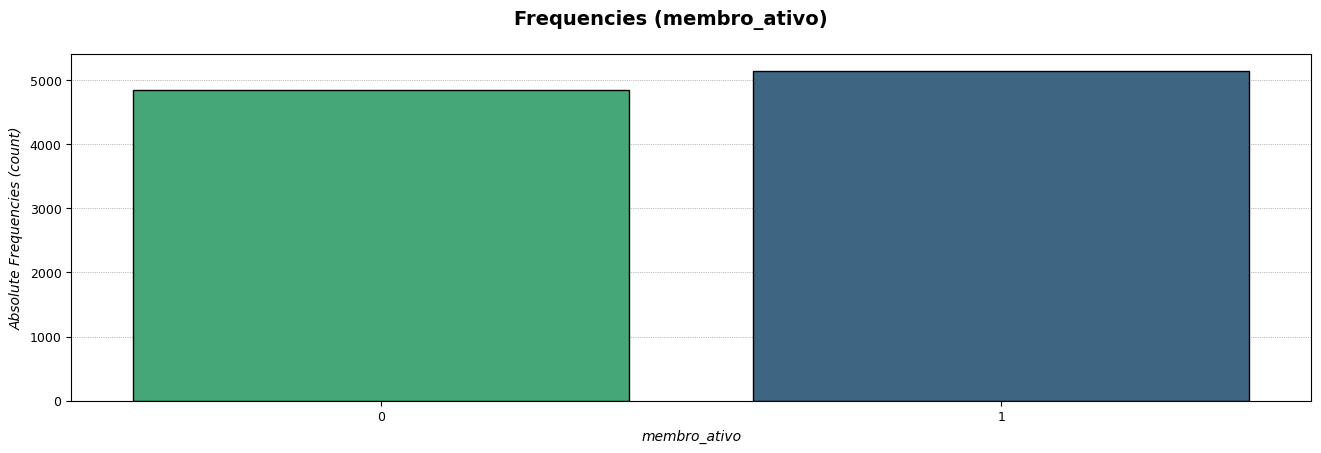

In [19]:
utils.plot_nominal_variables_distributions(qualitative_vars_df[list_nominal_vars])

#### Variáveis Ordinais

In [20]:
dict_ordinal_vars = {'escala_fico': ['too bad', 'bad', 'good', 'very good', 'excellent']}

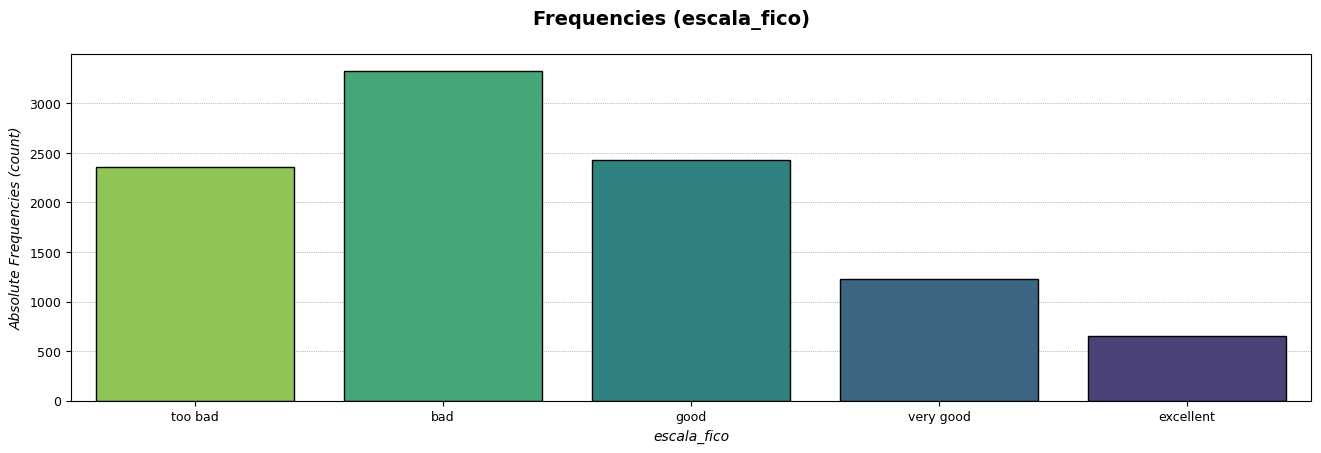

In [21]:
utils.plot_ordinal_variables_distributions(qualitative_vars_df, dict_ordinal_vars)

### Variáveis Quantitativas

- **Variáveis quantitativas contínuas**: score_credito, idade, saldo, salário estimado;
- **Variáveis quantitativas discretas**: tempo_permanencia, numero_de_contas;

In [22]:
quantitative_vars_df = df.select_dtypes(include= ['int64', 'float64'])

#### Variáveis Contínuas

In [23]:
list_continuous_vars = ['score_credito', 'idade', 'saldo', 'salario_estimado']

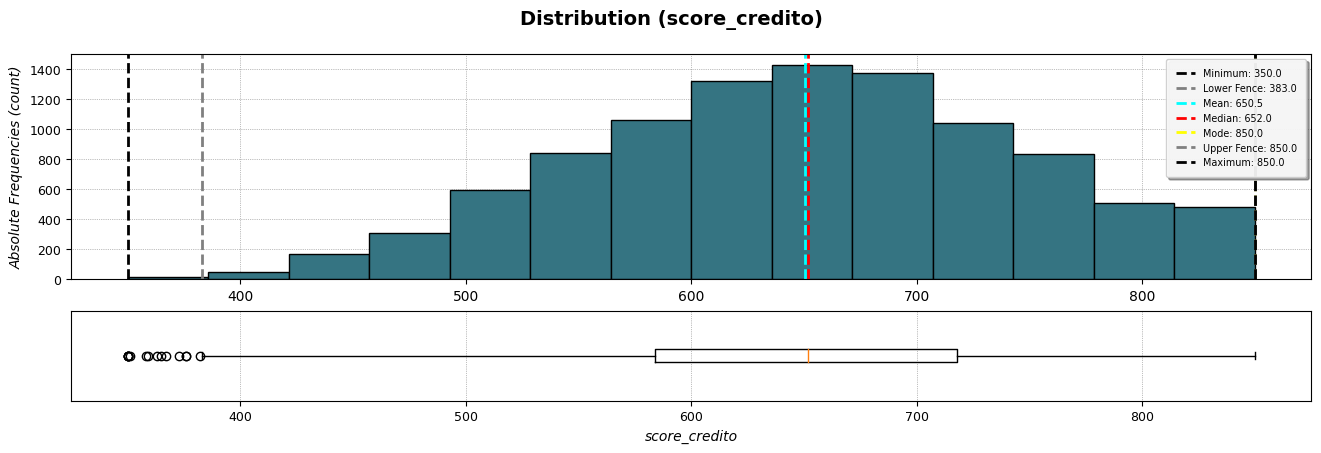

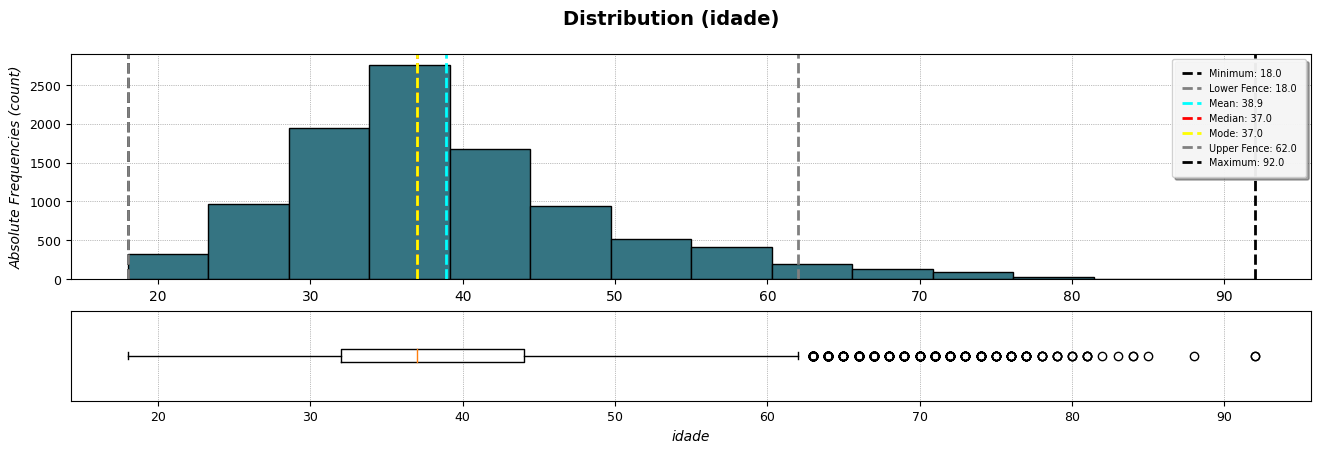

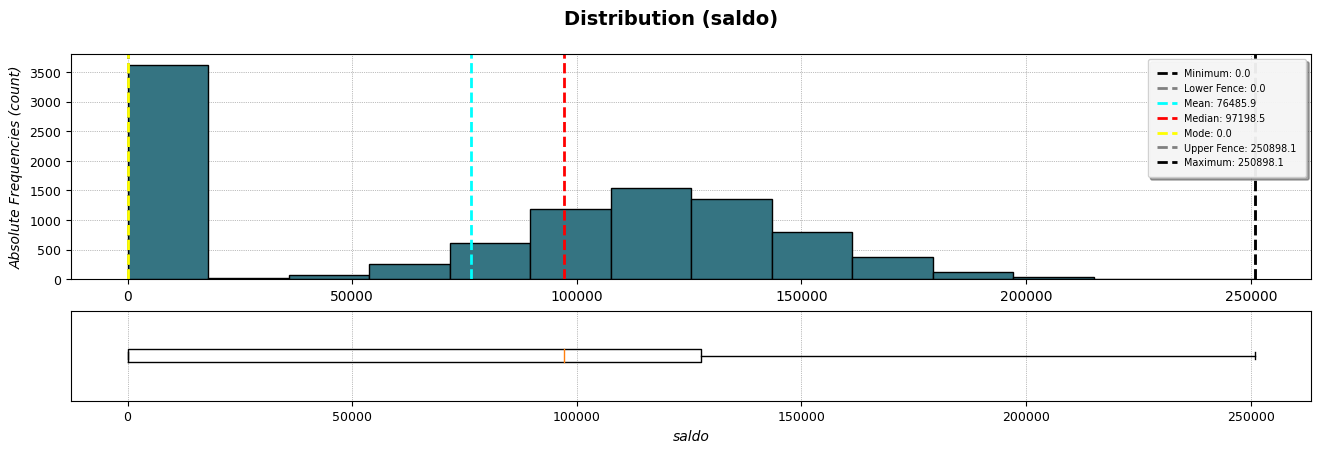

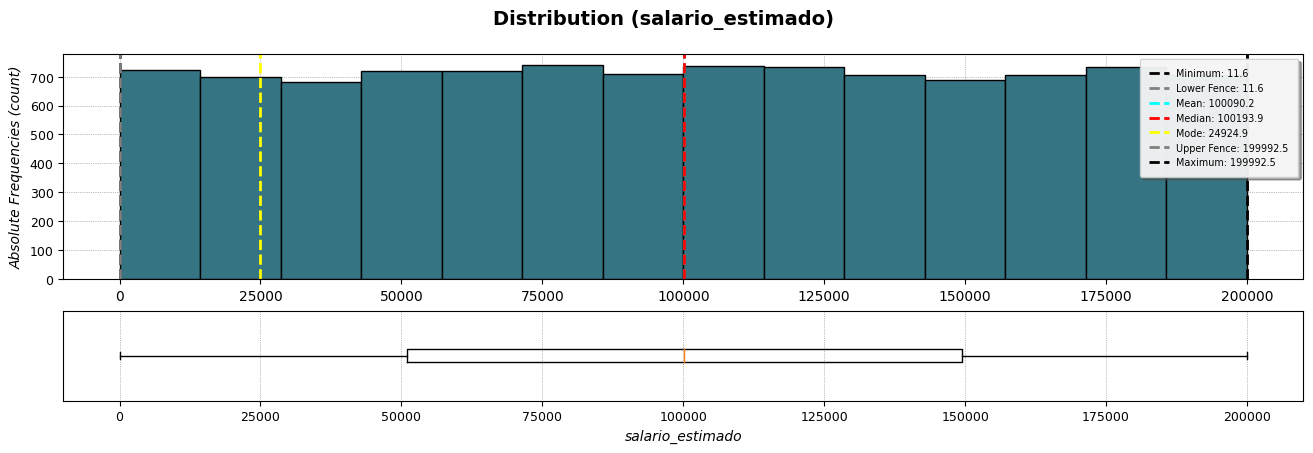

In [24]:
utils.plot_continuous_variables_distributions(quantitative_vars_df[list_continuous_vars])

In [25]:
utils.descriptive_statistics_continuous_variables(quantitative_vars_df[list_continuous_vars])

,Valores Únicos,Desv. Padrão,Variância,Assimetria,Curtose,Normalidade (p-value)
score_credito,460,96.653,9.341860e+03,-0.072,-0.426,9.716147e-04
idade,70,10.488,1.099940e+02,1.011,1.395,3.492314e-89
saldo,6382,62397.405,3.893436e+09,-0.141,-1.489,0.000000e+00
salario_estimado,9999,57510.493,3.307457e+09,0.002,-1.182,7.781996e-27


#### Variáveis Discretas

In [26]:
list_discrete_vars = ['tempo_permanencia', 'numero_de_contas']

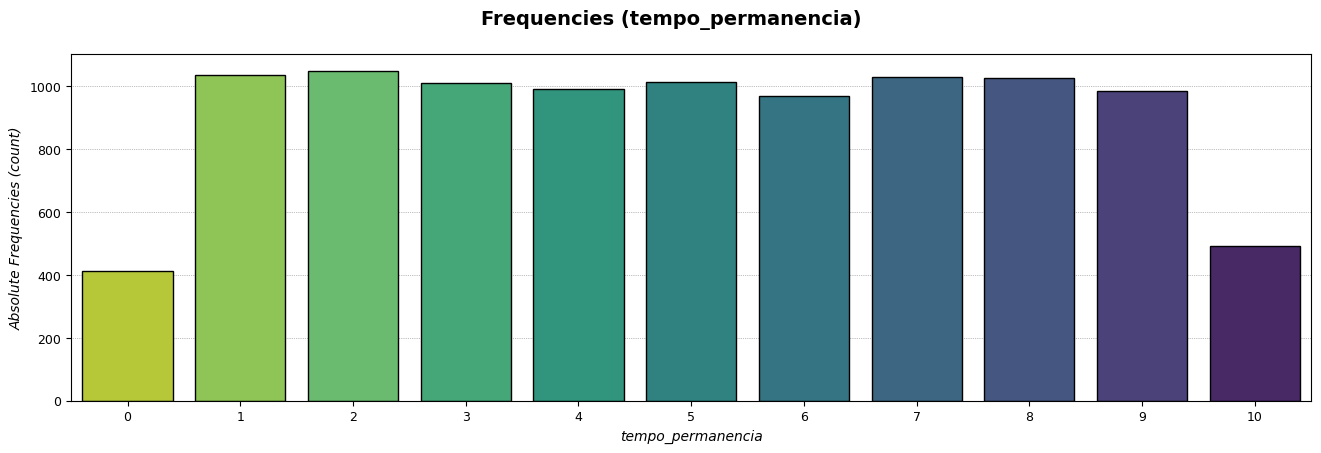

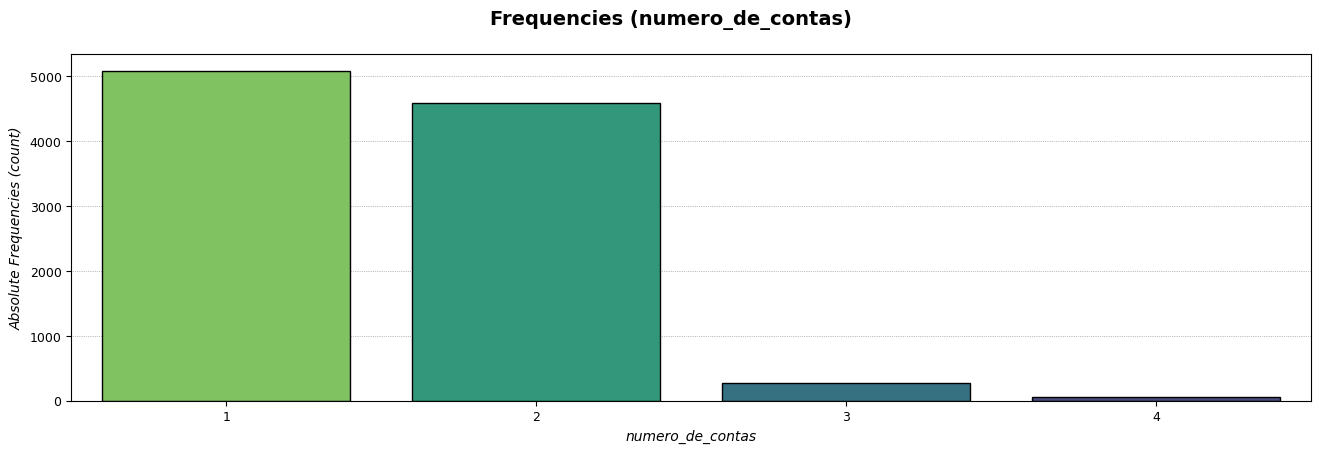

In [27]:
utils.plot_discrete_variables_distributions(quantitative_vars_df[list_discrete_vars])

### Nota:


- **Score de Crédito**:
    1. Existencia de outliers significativos abaixo de 400 pontos, o que indica a existência de um pequeno grupo de clientes com scores de crédito excepcionalmente baixos;
    2. A moda é de 850 pontos, o valor mais alto possível, o que significa que há um grupo notável de clientes com excelente crédito;
    
    
- **Idade**:
    1. A maioria dos clientes está na faixa etária entre 30 e 50 anos, com uma distribuição simétrica em torno dos 37 anos;
    2. Existe uma presença de clientes mais idosos, e alguns aparecem como outliers, com idades superiores a 62 anos;


- **Saldo**:
    1. A distribuição do saldo das contas é bastante assimétrica, com a maioria dos usuários possuindo saldos baixos ou próximos de zero.
    2. Porém, há uma pequena porcentagem de clientes com saldos muito altos, o que puxa a média para cima e gera uma grande discrepância entre a média e a mediana, sugerindo que enquanto a maioria possui saldos modestos, e alguns poucos possuem valores consideravelmente altos.


- **Salário Estimado**:
    1. A distribuição é praticamente uniforme, sugere que o banco atende a uma ampla gama de clientes com salários variados.
    2.  O valor mínimo do salário estimado é extremamente baixo (11,6);
    
    
- **Tempo Permanência**:
    1. Para cada tempo de permanência, existem em torno de 1000 cliente, trazendo uniformidade a variável. 
    2. O que chama atenção é o 1º e 10º ano, sugerindo talvez, uma problema de aquisição de clientes ou rotatividade a partir do 9º ano.
    
    
- **Número de Contas**:
    1. Mais da metade dos clientes possuem apenas 1 conta, e um pouco menos da metade possuem duas contas. Menos de 5% dos clientes possuem entre 3 a 4 contas.

## Análise Bivariada (Variáveis Independentes x Variável Alvo)

### Variáveis Nominais x Variável Alvo

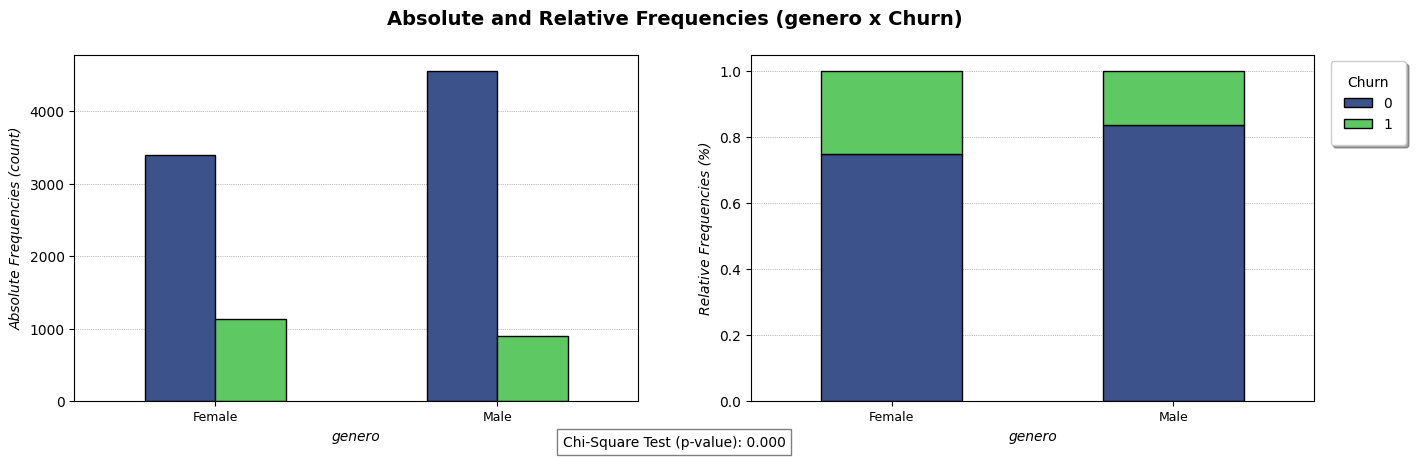

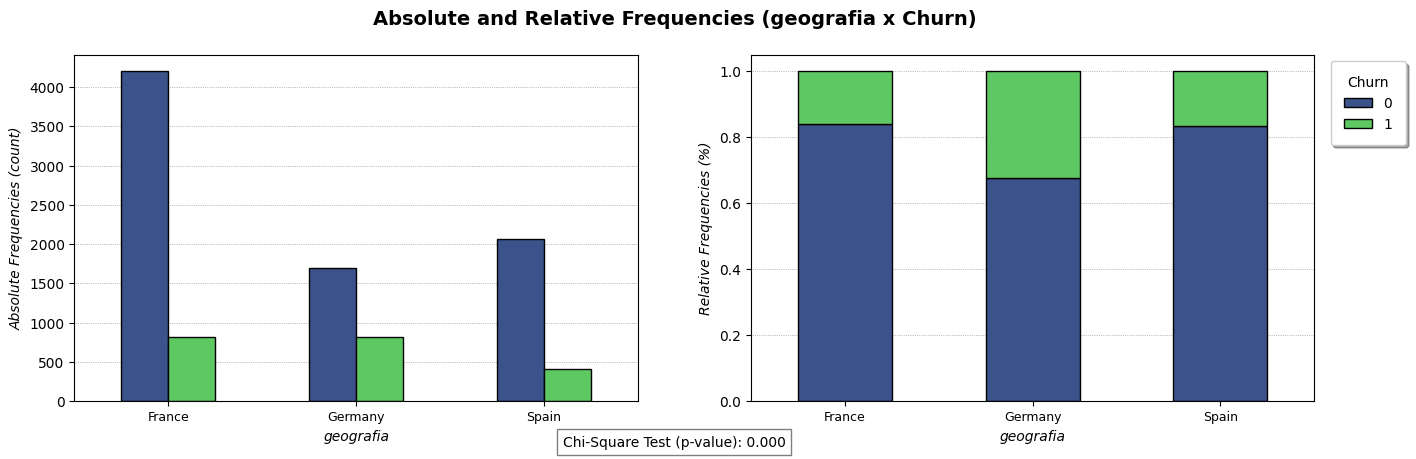

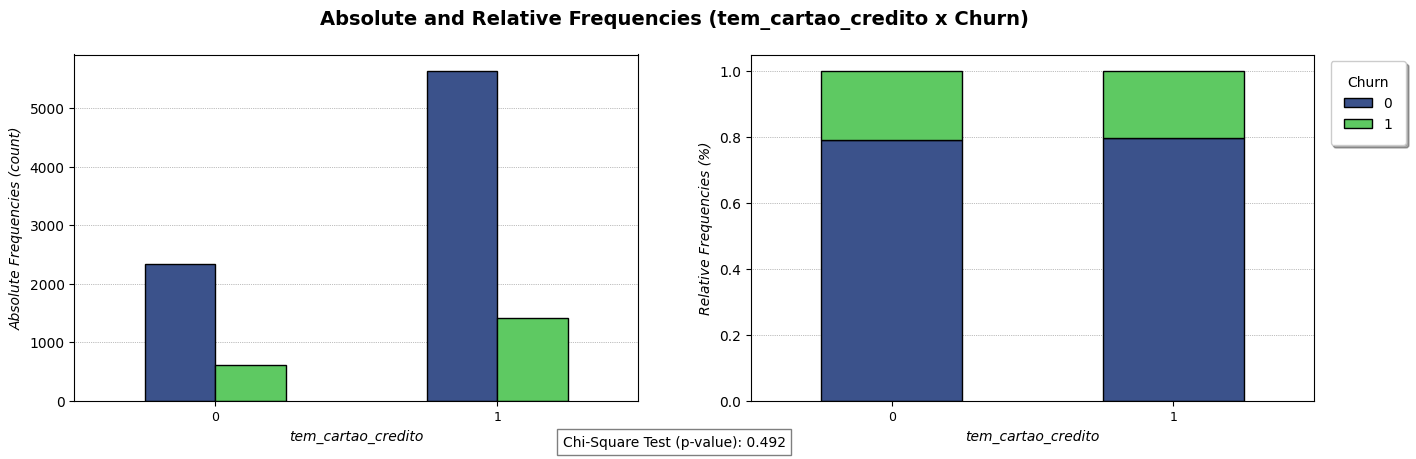

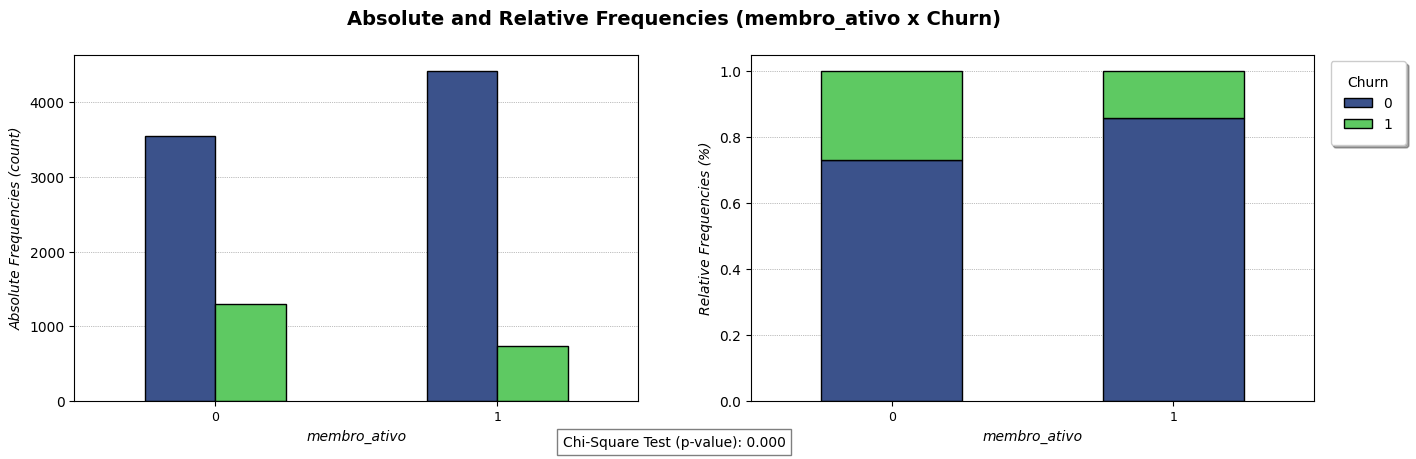

In [28]:
utils.plot_bivariate_analysis_qualitative_target_and_nominal_independent_vars(target_var_df, qualitative_vars_df[list_nominal_vars])

**Chi-Square Test (*h0*)**: As frequências observadas são iguais às esperadas.

### Variáveis Ordinais x Variável Alvo

In [29]:
list_ordinal_vars = list(dict_ordinal_vars.keys())

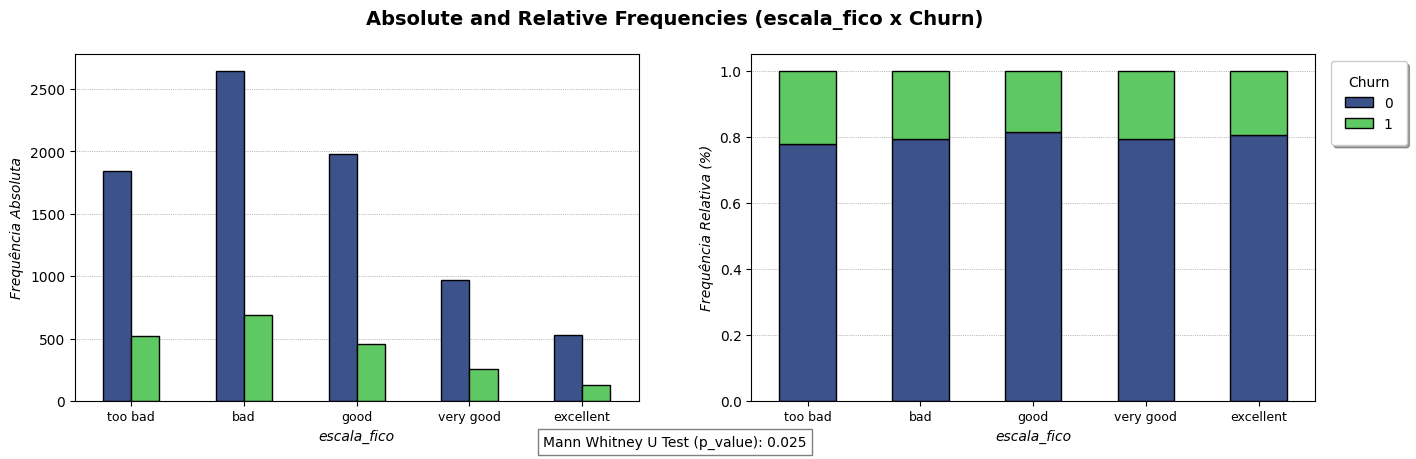

In [30]:
utils.plot_bivariate_analysis_qualitative_target_and_ordinal_independent_vars(target_var_df, qualitative_vars_df[list_ordinal_vars], dict_ordinal_vars)

### Variáveis Discretas x Variável Alvo

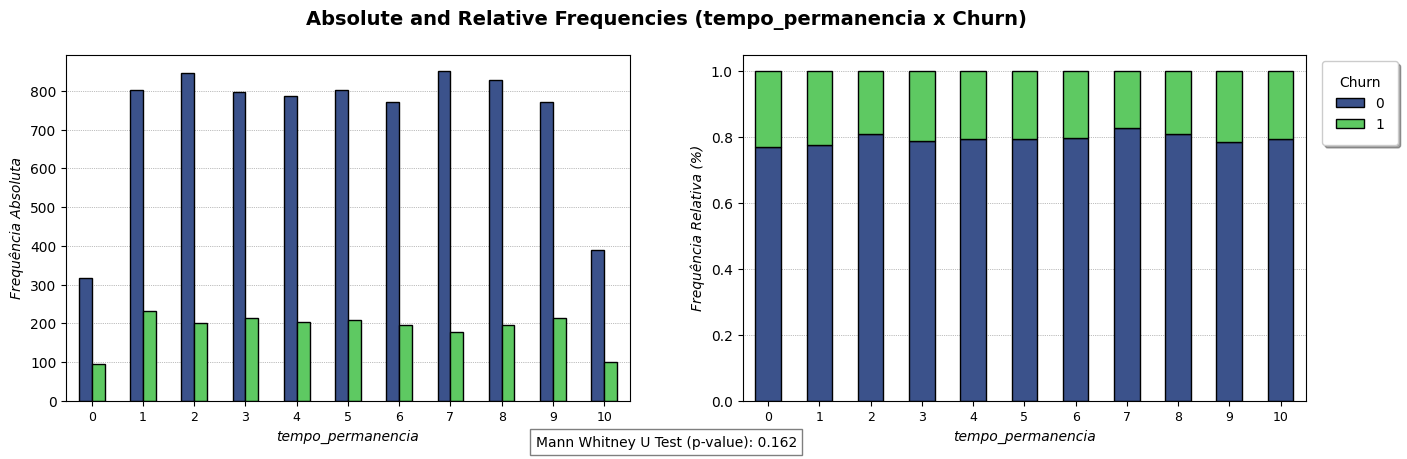

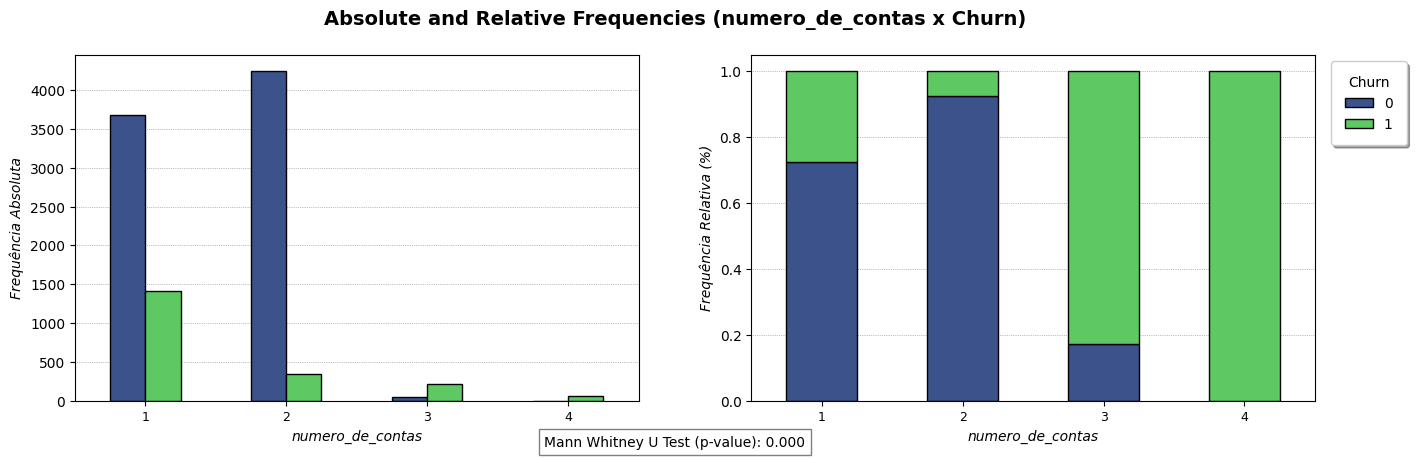

In [31]:
utils.plot_bivariate_analysis_qualitative_target_and_discrete_independent_vars(target_var_df, quantitative_vars_df[list_discrete_vars])

### Variáveis Contínuas x Variável Alvo


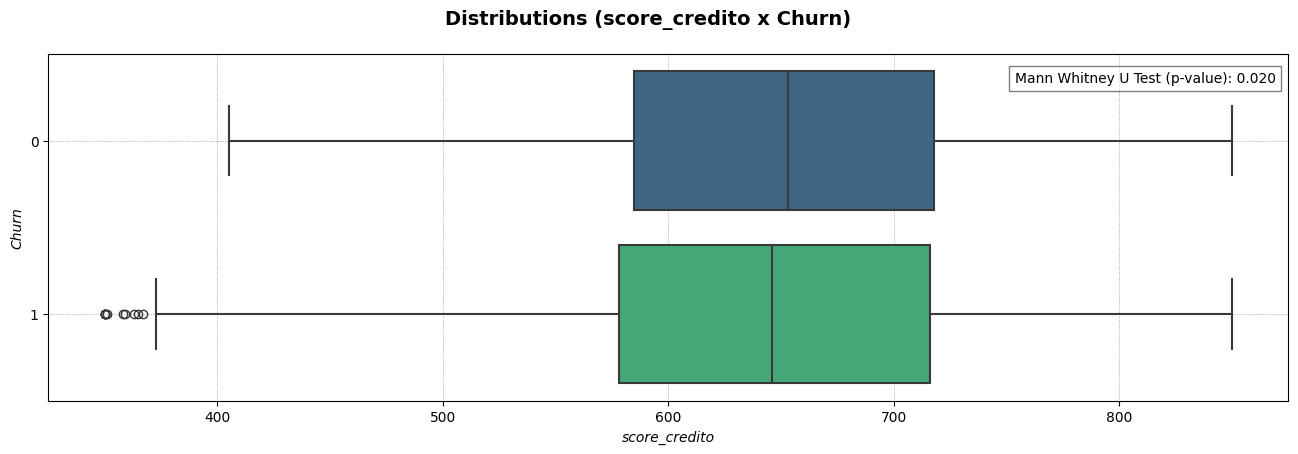

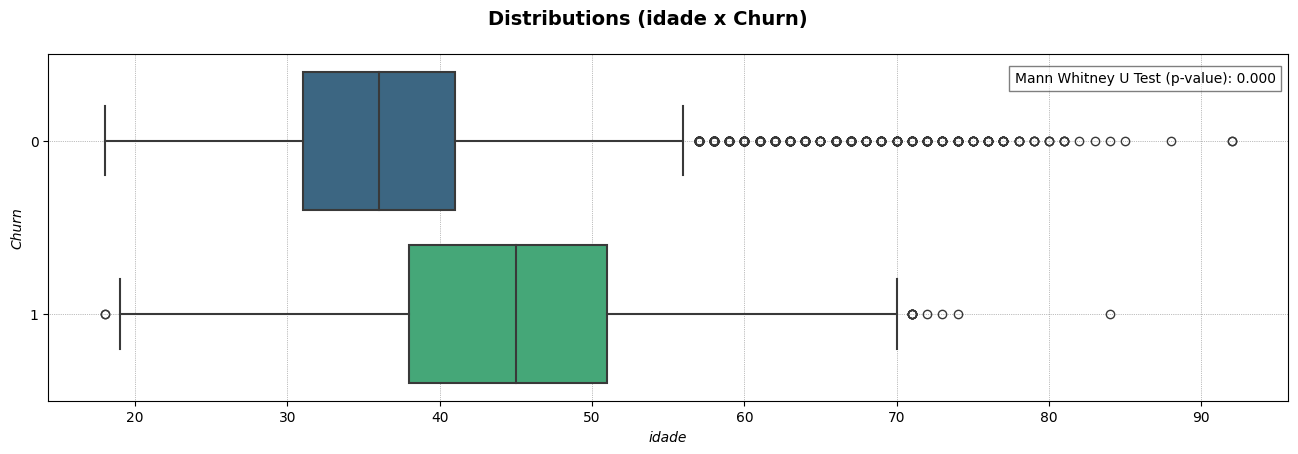

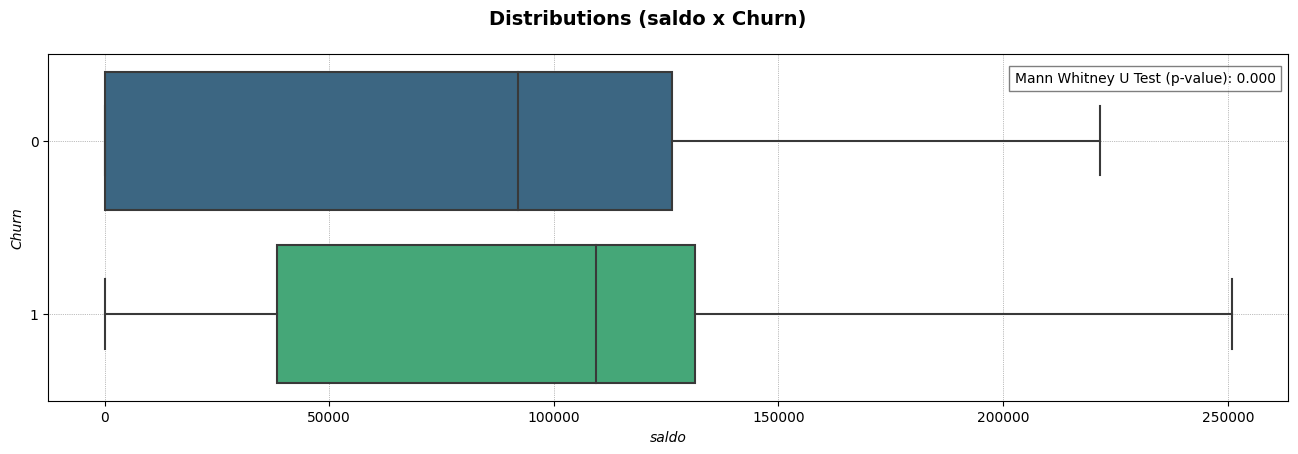

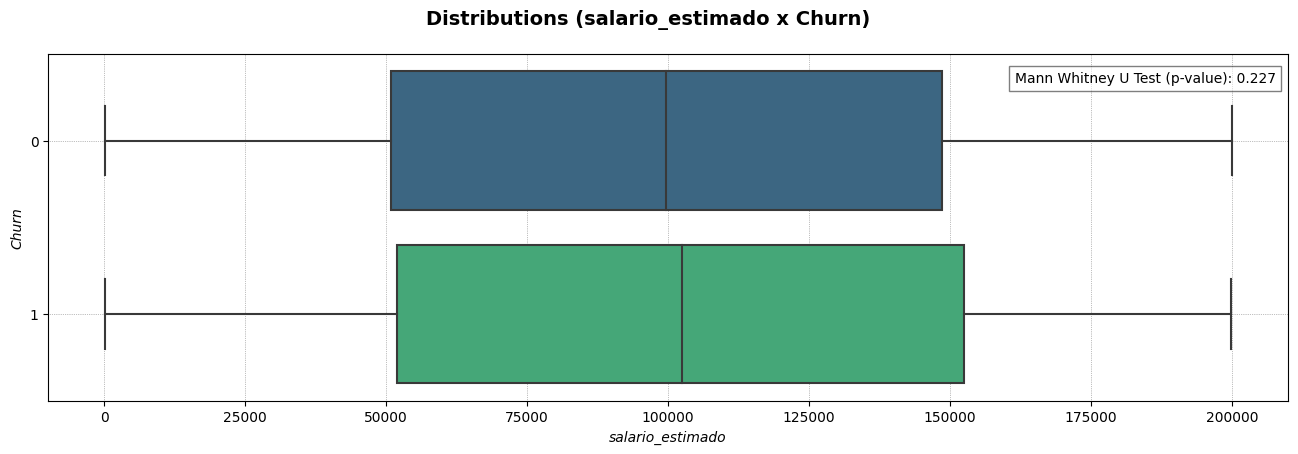

In [32]:
utils.plot_bivariate_analysis_qualitative_target_and_continuous_independent_vars(target_var_df, quantitative_vars_df[list_continuous_vars])

In [33]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

## Multivariate Analysis

### Categorical Variables

In [ ]:
categorical_dataframe = categorical_attributes

#calculate Cramer's V
cramer_v1 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['geografia'])
cramer_v2 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['genero'])
cramer_v3 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['tem_cartao_credito'])
cramer_v4 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['membro_ativo'])
cramer_v5 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['escala_fico'])
cramer_v6 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['Churn'])

cramer_v7 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['geografia'])
cramer_v8 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['genero'])
cramer_v9 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['tem_cartao_credito'])
cramer_v10 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['membro_ativo'])
cramer_v11 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['escala_fico'])
cramer_v12 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['Churn'])

cramer_v13 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['geografia'])
cramer_v14 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['genero'])
cramer_v15 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['tem_cartao_credito'])
cramer_v16 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['membro_ativo'])
cramer_v17 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['escala_fico'])
cramer_v18 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['Churn'])

cramer_v19 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['geografia'])
cramer_v20 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['genero'])
cramer_v21 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['tem_cartao_credito'])
cramer_v22 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['membro_ativo'])
cramer_v23 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['escala_fico'])
cramer_v24 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['Churn'])

cramer_v25 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['geografia'])
cramer_v26 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['genero'])
cramer_v27 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['tem_cartao_credito'])
cramer_v28 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['membro_ativo'])
cramer_v29 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['escala_fico'])
cramer_v30 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['Churn'])

cramer_v31 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['geografia'])
cramer_v32 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['genero'])
cramer_v33 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['tem_cartao_credito'])
cramer_v34 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['membro_ativo'])
cramer_v35 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['escala_fico'])
cramer_v36 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['Churn'])

#final dataset
cramer_v_dataset = pd.DataFrame({'geografia': [cramer_v1, cramer_v2, cramer_v3, cramer_v4, cramer_v5, cramer_v6],
                                 'genero': [cramer_v7, cramer_v8, cramer_v9, cramer_v10, cramer_v11, cramer_v12], 
                                 'tem_cartao_credito': [cramer_v13, cramer_v14, cramer_v15, cramer_v16, cramer_v17, cramer_v18],
                                 'membro_ativo': [cramer_v19, cramer_v20, cramer_v21, cramer_v22, cramer_v23, cramer_v24],
                                 'escala_fico': [cramer_v25, cramer_v26, cramer_v27, cramer_v28, cramer_v29, cramer_v30],
                                 'Churn': [cramer_v31, cramer_v32, cramer_v33, cramer_v34, cramer_v35, cramer_v36]})

cramer_v_dataset = cramer_v_dataset.set_index(cramer_v_dataset.columns)

sns.heatmap(cramer_v_dataset, annot= True);

### Numeric Variables

In [ ]:
df4['Churn'] = df4['Churn'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
variables =  df4[['score_credito', 'idade', 'saldo', 'salario_estimado', 'tempo_permanencia', 'numero_de_contas', 'Churn']]
correlation = variables.corr(method= 'spearman')
sns.heatmap(correlation, annot= True);

## Note:
Informações Importantes:

**Análise Univariada:**
- ***score_credito***: existem poucos outliers que não são tão relevantes devido ao valor da curtose, logo podem permanecer.
- ***idade***: existem muitos outliers relevantes na variável, acima de 62 anos. Vale tratá-los.
- ***salario_estimado***: mais de 36% dos clientes possuem contas zeradas, evidenciado pela variável .
- ***numero_de_contas***: apenas 3,26% de cleintes possuem 3 ou 4 contas.
- ***geografia***: metade dos clientes são da França (50,14%). A outra metade se divide praticamente igual entre Alemanha (25.09%) e Espanha (24.77%)
- ***tem_cartao_credito***: 70.55% dos clientes possuem cartão de crédito.
- ***escala_fico***: menos de 20% possuem scores muito bons ou excelentes.

**Análise Bivariada e Multivariada**
- ***score_credito***: não há efeito significativo na variável Churn. Apenas poucos outliers com scores próximos de 350 na distribuição de clientes positivos para Churn. Correlação muito fraca com a variável Churn = -0.023
- ***idade***: <span style="background:LightGreen">pode ter efeito significativo na variável Churn. Clientes negativos para churn tendem a ser mais novos (metade dos dados entre 32 - 42 anos e presença de muitos outliers a partir de 56 anos) e clientes positivos tendem a ser mais velhos (metade dos dados entre 36 - 52 anos e presença de poucos outliers a partir de 70 anos e abaixo de 19). Correlação moderada com a variável Churn = 0.32</span>
- ***saldo***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. A diferença que chama atenção entre as distribuições, é a presença de 0, onde clientes positivos para churn e que possuem o saldo zerado são quase o dobro em relação aos clientes negativos para churn e que possuem o saldo zerado. Correlação fraca com a variável Churn = 0.11</span>
- ***salario_estimado***: não deve ter efeito significativo na variável Churn. Apenas chama atenção um detalhe, onde salários maiores, próximos de US200000.00 tem uma proporção de Churn maior. Correlação muito fraca com a variável Churn = 0.012
- ***tempo_permanencia***: não deve ter efeito significativo na variável Churn. Todas os anos possuem quase o mesmo padrão, onde 20% querem sair do banco e 80% não. Correlação muito fraca com a variável Churn = -0.014
- ***numero_de_contas***: <span style="background:LightYellow">pode ter pouco efeito na variável Churn. 100% dos que possuem 4 contas e 80% dos que possuem 3 contas querem sair do banco, porém esses clientes que possuem 3 ou 4 representam um porcentagem muito pequena do conjunto de dados (menos de 5%). Mas possui uma correlação fraca com a variável Churn = -0.13</span>

- ***geografia***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. De todos os clientes que residem na França ou na Espanha, apenas 16% querem sair do banco. Mas a Alemanha tem essa proporção dobrada, 32% querem sair do banco. Correlação fraca com a variável Churn = 0.17</span>

- ***genero***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. Mulheres querem sair do banco mais que os homens. 25% das mulheres e 16% dos homens. Correlação fraca com a variável Churn = 0.11</span>

- ***tem_cartao_credito***: não há efeito significativo na variável Churn. De todos os cliente que possuem cartão ou não, apenas 20% querem sair do banco. Correlação muito fraca com a variável Churn = 0.0069

- ***membro_ativo***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. Essa variável possui quase o mesmo comportamento da variável gênero, onde Clientes inativos querem sair do banco mais que os inativos. 26%  dos inativos e 14% dos ativos. Correlação fraca com a variável Churn = 0.16</span>

- ***escala_fico***: não há efeito significativo na variável Churn. Todas as classes possuem quase o mesmo padrão, onde 20% querem sair do banco e 80% não. Correlação muito fraca com a variável Churn = 0.03

Observação:
- Como o conjunto de dados possui muita dispersão, estou usando a relação de correlação de Jacob Cohen (1992):

	- corr = 0,10 => correlação fraca.
    - corr = 0,30 => correlação moderada.
    - corr = 0,50 => correlação forte

Próxima versão: 
- Utilizar testes estatísticos para validar comportamento das distribuições;
- Testar método PolynomialFeatures sklearn para criação de Features Interactions;
- Melhorar funções para plotagens dos gráficos;

# Feature Engineering (Data Preparation)

In [ ]:
df5 = df4.copy()

## Data Filtering

In [ ]:
data_for_filtering = df5.copy()

In [ ]:
columns_to_delete = ['numero_linha', 'id_cliente', 'sobrenome']
filtered_data = data_for_filtering.drop(columns_to_delete, axis= 1) 

In [ ]:
filtered_data.head()

## Splitting Dataframe into Training and Test Dataset

In [ ]:
X = filtered_data
y = filtered_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 33)

In [ ]:
X_train.reset_index(drop= True, inplace= True)
X_test.reset_index(drop= True, inplace= True)
y_train.reset_index(drop= True, inplace= True)
y_test.reset_index(drop= True, inplace= True)

In [ ]:
sns.countplot(x= y_train);

In [ ]:
sns.countplot(x= y_test);

## Creation of the New Features II or Feature Interactions

- A estratégia na criação de novas variáveis é usar variáveis reconhecidas pelo brainstorm de negócio e com efeitos significativos na variável Churn evidenciada pela análise exploratória de dados e combiná-las para potencializar seus impactos. 

**Brainstorm**

Principais fatores para um cliente querer fechar uma conta/sair de um banco:

1. Corte de gastos

		P: O que leva uma pessoa a cortar gastos?
		R: Ou o salário foi reduzido, ou faltou organização financeira, entrando em endividamento.
		Variáveis disponíveis impactadas: salario_estimado baixo, score_credito baixo, saldo baixo, tem_cartao_credito, numero de contas alto
	
2. Insatisfação com o Banco

		P: O que leva uma pessoa a estar insatisfeita com um banco?
    	R: Suporte ruim, taxas elevadas, falta de transparência, problemas com transações ou aplicações, falta na segurança dos dados.
		Variáveis disponíveis impactadas: tempo_permanencia curto, negativo para membro_ativo.

3. Concorrente tem mais benefícios
		
        Variáveis disponíveis impactadas: nenhuma.

Principais fatores para um cliente não querer fechar uma conta/sair de um banco:

1. Comodidade aliado com benefícios, e bom produto.
		Variáveis disponíveis que impactam a causa: tempo_permanencia, membro_ativo, numero_de_contas, tem_cartao_credito

**Variáveis**

- Variáveis do Brainstorm: [<span style="background:LightYellow">'saldo', 'membro_ativo', 'numero_de_contas'</span>, 'salario_estimado', 'score_credito', 'tem_cartao_credito', 'tempo_permanencia']
- Variáveis da Análise Exploratória: [<span style="background:LightGreen">'idade'</span>, <span style="background:LightYellow">'saldo', 'geografia', 'genero', 'membro_ativo'</span>, 'salario_estimado'] 

Idéias de Variáveis:

	- saldo por salário (saldo/salario_estimado) -> combinação de impacto fraco + impacto fraco
	- saldo por score de crédito (saldo/score_credito) -> combinação de impacto fraco + impacto muito fraco
    - saldo por numero de contas (saldo/numero_contas) -> combinação de impacto fraco + impacto fraco
	- saldo acumulado por cada ano de idade (saldo/idade) > combinação de impacto fraco + impacto forte
	- salário por numero de contas (salario_estimado/numero_de_contas) -> combinação de impacto fraco + impacto fraco
	- salário por score de crédito (salario_estimado/score_credito) -> combinação de impacto fraco + impacto muito fraco
	- salário total em x ano de permanencia (salario_estimado * tempo_permanencia) -> combinação de impacto fraco + impacto muito fraco
	- salário por idade (salario_estimado/idade) -> combinação de impacto fraco + impacto forte
	- score de crédito por idade (score_credito/idade) -> combinação de impacto muito fraco + impacto forte
	- score de crédito por numero de contas (score_credito/numero_de_contas) -> combinação de impacto muito fraco + impacto fraco
	- tempo no banco por idade (tempo_permanencia/idade) -> combinação de impacto muito fraco + impacto forte
    - tempo no banco por numero de contas (tempo_permanencia/numero_de_contas) combinação de impacto muito fraco + impacto fraco
	- numero de contas por idade (numero_de_contas/idade) -> combinação de impacto fraco + impacto forte
	- numero de contas por tempo permanencia (numero_de_contas/tempo_permanencia) -> combinação impacto fraco + impacto muito fraco
	- média de saldo por idade (media de saldo por agrupamento de idade) -> combinação de impacto fraco + impacto forte
	- média de salário por idade (media de salario_estimado por agrupamento de idade) -> combinação de impacto fraco + impacto forte
    
Observação:

- Criei muitas métricas/features nesse ciclo por dois motivos:

		1. Os significados das variáveis e o período da extração dos dados não são bem definidos. Logo, com mais features criadas, maior a chance de encontrar alguma interação que tenha uma correlação significativa com a variável resposta.
        2. Features Interactions são úteis para modelos lineares. Já modelos baseados em árvore de decisão, já fazem interações desse tipo em seu funcionamento.

In [ ]:
X_train['saldo_por_salario'] = X_train['saldo'] / X_train['salario_estimado']
X_test['saldo_por_salario'] = X_test['saldo'] / X_test['salario_estimado']

In [ ]:
X_train['saldo_por_score'] = X_train['saldo'] / X_train['score_credito']
X_test['saldo_por_score'] = X_test['saldo'] / X_test['score_credito']

In [ ]:
X_train['saldo_por_numero_contas'] = X_train['saldo'] / X_train['numero_de_contas']
X_test['saldo_por_numero_contas'] = X_test['saldo'] / X_test['numero_de_contas']

In [ ]:
X_train['saldo_por_idade'] = X_train['saldo'] / X_train['idade']
X_test['saldo_por_idade'] = X_test['saldo'] / X_test['idade']

In [ ]:
X_train['salario_por_numero_de_contas'] = X_train['salario_estimado'] / X_train['numero_de_contas']
X_test['salario_por_numero_de_contas'] = X_test['salario_estimado'] / X_test['numero_de_contas']

In [ ]:
X_train['salario_por_score'] = X_train['salario_estimado'] / X_train['score_credito']
X_test['salario_por_score'] = X_test['salario_estimado'] / X_test['score_credito']

In [ ]:
X_train['salario_x_tempo_permanencia'] = X_train['salario_estimado'] * X_train['tempo_permanencia']
X_test['salario_x_tempo_permanencia'] = X_test['salario_estimado'] * X_test['tempo_permanencia']

In [ ]:
X_train['salario_por_idade'] = X_train['salario_estimado'] / X_train['idade']
X_test['salario_por_idade'] = X_test['salario_estimado'] / X_test['idade']

In [ ]:
X_train['score_credito_por_idade'] = X_train['score_credito'] / X_train['idade']
X_test['score_credito_por_idade'] = X_test['score_credito'] / X_test['idade']

In [ ]:
X_train['score_credito_por_numero_de_contas'] = X_train['score_credito'] / X_train['numero_de_contas']
X_test['score_credito_por_numero_de_contas'] = X_test['score_credito'] / X_test['numero_de_contas']

In [ ]:
X_train['tempo_permanencia_por_idade'] = X_train['tempo_permanencia'] / X_train['idade']
X_test['tempo_permanencia_por_idade'] = X_test['tempo_permanencia'] / X_test['idade']

In [ ]:
X_train['tempo_permanencia_por_numero_de_contas'] = X_train['tempo_permanencia'] / X_train['numero_de_contas']
X_test['tempo_permanencia_por_numero_de_contas'] = X_test['tempo_permanencia'] / X_test['numero_de_contas']

In [ ]:
X_train['numero_contas_por_idade'] = X_train['numero_de_contas'] / X_train['idade']
X_test['numero_contas_por_idade'] = X_test['numero_de_contas'] / X_test['idade']

In [ ]:
X_train['numero_de_contas_por_tempo_permanencia'] = X_train['numero_de_contas'] / X_train['tempo_permanencia']
X_train['numero_de_contas_por_tempo_permanencia'] = X_train['numero_de_contas_por_tempo_permanencia'].apply(lambda x: 0 if x == np.inf else x)
X_test['numero_de_contas_por_tempo_permanencia'] = X_test['numero_de_contas'] / X_test['tempo_permanencia']
X_test['numero_de_contas_por_tempo_permanencia'] = X_test['numero_de_contas_por_tempo_permanencia'].apply(lambda x: 0 if x == np.inf else x)

In [ ]:
# X_train
mean_balance_for_age = X_train[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'media_saldo_por_idade']

#merge'
X_train = pd.merge(X_train, mean_balance_for_age, on= 'idade', how= 'left')

#X_test
mean_balance_for_age = X_test[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'media_saldo_por_idade']

#merge'
X_test = pd.merge(X_test, mean_balance_for_age, on= 'idade', how= 'left')

In [ ]:
#X_train
mean_salary_for_age = X_train[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'media_salarial_por_idade']

#merge'
X_train = pd.merge(X_train, mean_salary_for_age, on= 'idade', how= 'left')

#X_test
mean_salary_for_age = X_test[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'media_salarial_por_idade']

#merge'
X_test = pd.merge(X_test, mean_salary_for_age, on= 'idade', how= 'left')

In [ ]:
X_train.sample(5)

### Exploratory Analysis of New Features

#### Univariate Analysis

In [ ]:
list_variables = ['saldo_por_salario',
       'saldo_por_score', 'saldo_por_numero_contas', 'saldo_por_idade',
       'salario_por_numero_de_contas', 'salario_por_score',
       'salario_x_tempo_permanencia', 'salario_por_idade',
       'score_credito_por_idade', 'score_credito_por_numero_de_contas',
       'tempo_permanencia_por_idade', 'tempo_permanencia_por_numero_de_contas',
       'numero_contas_por_idade', 'numero_de_contas_por_tempo_permanencia',
       'media_saldo_por_idade', 'media_salarial_por_idade']

plot_univariate_numeric_distributions(X_train, list_numerical_variables= list_variables)

#### Bivariate Analysis

In [ ]:
tuple_figsize = (40, 80)
plot_bivariate_numeric_distribuitions(X_train, list_variables, 'Churn', tuple_figsize= tuple_figsize)

#### Multivariate Analysis

In [ ]:
variables =  X_train.drop(columns= ['geografia', 'genero', 'tem_cartao_credito', 'membro_ativo', 'escala_fico', 'score_credito', 'idade', 'saldo', 'salario_estimado', 'tempo_permanencia', 'numero_de_contas'])
correlation = variables.corr(method= 'spearman')
plt.figure(figsize= (20, 10))
sns.heatmap(correlation, annot= True);

In [ ]:
# Retirando variavel resposta dos dados de Teste
X_train.drop(columns= ['Churn'], inplace= True)
X_test.drop(columns= ['Churn'], inplace= True)

## Scaling I (Encoding)

### One Hot Encoding

In [ ]:
one_hot_encoder = OneHotEncoder(sparse= False) #cria novas colunas com valores numéricos (1 ou 0) para substituir dados categóricos 

### *geografia e gênero*

In [ ]:
df_train_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X_train[['geografia', 'genero']]))
df_test_encoded = pd.DataFrame(one_hot_encoder.transform(X_test[['geografia', 'genero']]))

# Renomear as colunas codificadas
encoded_cols = one_hot_encoder.get_feature_names(['geografia', 'genero'])
df_train_encoded.columns = encoded_cols
df_test_encoded.columns = encoded_cols

# Concatenando colunas codificadas com dataframes de treino e teste
X_train = pd.concat([X_train, df_train_encoded], axis=1)
X_test = pd.concat([X_test, df_test_encoded], axis=1)

#Excluindo colunas "antigas"
X_train.drop(columns= ['geografia', 'genero'], inplace= True)
X_test.drop(columns= ['geografia', 'genero'], inplace= True)

### *tem_cartao_credito*

In [ ]:
X_train['tem_cartao_credito'] = X_train['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['tem_cartao_credito'] = X_test['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)

### *membro_ativo*

In [ ]:
X_train['membro_ativo'] = X_train['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['membro_ativo'] = X_test['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)

### Label Encoding

### *escala_fico*

In [ ]:
escala_fico_dict = {'too bad': 0, 'bad': 1, 'good': 2, 'very good': 3, 'excellent': 4}
X_train['escala_fico'] = X_train['escala_fico'].apply(lambda x: escala_fico_dict[x])
X_test['escala_fico'] = X_test['escala_fico'].apply(lambda x: escala_fico_dict[x])

### Response Variable (Churn)

- O encoding da variável resposta foi feita no início da análise multivariada de variáveis numéricas

In [ ]:
X_train.sample(5)

In [ ]:
X_test.sample(5)

## Scaling II (Normalization) 

In [ ]:
numeric_attributes_train_data = X_train.select_dtypes(include= ['int64', 'float64'])
numeric_attributes_train_data.drop(columns= ['escala_fico', 'tem_cartao_credito', 'membro_ativo'], inplace= True)
pd.options.display.max_rows = numeric_attributes_train_data.shape[1]

In [ ]:
# Estatística descritiva de todo conjunto de dados antes da criação de novas features
numeric_descriptive_statistical(numeric_attributes)

In [ ]:
# Estatística descritiva dos dados de treino depois da criação de novas features
numeric_descriptive_statistical(numeric_attributes_train_data)

### Normalization (or Rescaling)

In [ ]:
min_max_scaler = MinMaxScaler() #rescala para variáveis numéricas com distribuições que não possuem outliers 
standart_scaler = StandardScaler()
robust_scaler = RobustScaler() #rescala para variáveis numéricas com distribuições que possuem outliers 


# Neste ciclo, meu critério de normalização é a análise exploratória e valor de curtose:
    # valores < - 0.3, considero baixa presença outlier => min_max_scaler (score_credito, tempo_permanencia, saldo,  salario_estimado, 'saldo_por_score', 'saldo_por_numero_contas', 'saldo_por_idade', 'salario_por_idade', 'salario_por_numero_de_contas', 'salario_por_score', 'score_credito_por_numero_de_contas', 'tempo_permanencia_por_numero_de_contas')
    # -0.3 < valores < 0.5, considero presença razoável de outliers => standart_scaler (salario_x_tempo_permanencia)
    # valores > 0.5, considero presença significativa de outliers => robust_scaler (idade, saldo_por_salario, salario_por_idade, score_credito_por_idade, tempo_permanencia_por_idade, numero_contas_por_idade, numero_de_contas_por_tempo_permanencia, media_saldo_por_idade, media_salarial_por_idade)

#### *score_credito*

In [ ]:
X_train['score_credito'] = min_max_scaler.fit_transform(X_train[['score_credito']].values)
X_test['score_credito'] = min_max_scaler.transform(X_test[['score_credito']].values)

#### *tempo_permanencia*

In [ ]:
X_train['tempo_permanencia'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia']].values)
X_test['tempo_permanencia'] = min_max_scaler.transform(X_test[['tempo_permanencia']].values)

#### *saldo*

In [ ]:
X_train['saldo'] = min_max_scaler.fit_transform(X_train[['saldo']].values)
X_test['saldo'] = min_max_scaler.transform(X_test[['saldo']].values)

#### *salario_estimado*

In [ ]:
X_train['salario_estimado'] = min_max_scaler.fit_transform(X_train[['salario_estimado']].values)
X_test['salario_estimado'] = min_max_scaler.transform(X_test[['salario_estimado']].values)

#### *saldo_por_score*

In [ ]:
X_train['saldo_por_score'] = min_max_scaler.fit_transform(X_train[['saldo_por_score']].values)
X_test['saldo_por_score'] = min_max_scaler.transform(X_test[['saldo_por_score']].values)

#### *saldo_por_numero_contas*

In [ ]:
X_train['saldo_por_numero_contas'] = min_max_scaler.fit_transform(X_train[['saldo_por_numero_contas']].values)
X_test['saldo_por_numero_contas'] = min_max_scaler.transform(X_test[['saldo_por_numero_contas']].values)

#### *saldo_por_idade*

In [ ]:
X_train['saldo_por_idade'] = min_max_scaler.fit_transform(X_train[['saldo_por_idade']].values)
X_test['saldo_por_idade'] = min_max_scaler.transform(X_test[['saldo_por_idade']].values)

#### *salario_por_idade*

In [ ]:
X_train['salario_por_idade'] = min_max_scaler.fit_transform(X_train[['salario_por_idade']].values)
X_test['salario_por_idade'] = min_max_scaler.transform(X_test[['salario_por_idade']].values)

#### *salario_por_numero_de_contas*

In [ ]:
X_train['salario_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['salario_por_numero_de_contas']].values)
X_test['salario_por_numero_de_contas'] = min_max_scaler.transform(X_test[['salario_por_numero_de_contas']].values)

#### *salario_por_score*

In [ ]:
X_train['salario_por_score'] = min_max_scaler.fit_transform(X_train[['salario_por_score']].values)
X_test['salario_por_score'] = min_max_scaler.transform(X_test[['salario_por_score']].values)

#### *score_credito_por_numero_de_contas* 

In [ ]:
X_train['score_credito_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['score_credito_por_numero_de_contas']].values)
X_test['score_credito_por_numero_de_contas'] = min_max_scaler.transform(X_test[['score_credito_por_numero_de_contas']].values)

#### *tempo_permanencia_por_numero_de_contas*

In [ ]:
X_train['tempo_permanencia_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia_por_numero_de_contas']].values)
X_test['tempo_permanencia_por_numero_de_contas'] = min_max_scaler.transform(X_test[['tempo_permanencia_por_numero_de_contas']].values)

#### salario_x_tempo_permanencia

In [ ]:
X_train['salario_x_tempo_permanencia'] = standart_scaler.fit_transform(X_train[['salario_x_tempo_permanencia']].values)
X_test['salario_x_tempo_permanencia'] = standart_scaler.transform(X_test[['salario_x_tempo_permanencia']].values)

#### *idade*

In [ ]:
X_train['idade'] = robust_scaler.fit_transform(X_train[['idade']].values)
X_test['idade'] = robust_scaler.transform(X_test[['idade']].values)

#### *saldo_por_salario*

In [ ]:
X_train['saldo_por_salario'] = robust_scaler.fit_transform(X_train[['saldo_por_salario']].values)
X_test['saldo_por_salario'] = robust_scaler.transform(X_test[['saldo_por_salario']].values)

#### salario_por_idade

In [ ]:
X_train['salario_por_idade'] = robust_scaler.fit_transform(X_train[['salario_por_idade']].values)
X_test['salario_por_idade'] = robust_scaler.transform(X_test[['salario_por_idade']].values)

#### *score_credito_por_idade*

In [ ]:
X_train['score_credito_por_idade'] = robust_scaler.fit_transform(X_train[['score_credito_por_idade']].values)
X_test['score_credito_por_idade'] = robust_scaler.transform(X_test[['score_credito_por_idade']].values)

#### *tempo_permanencia_por_idade*

In [ ]:
X_train['tempo_permanencia_por_idade'] = robust_scaler.fit_transform(X_train[['tempo_permanencia_por_idade']].values)
X_test['tempo_permanencia_por_idade'] = robust_scaler.transform(X_test[['tempo_permanencia_por_idade']].values)

#### *numero_contas_por_idade*

In [ ]:
X_train['numero_contas_por_idade'] = robust_scaler.fit_transform(X_train[['numero_contas_por_idade']].values)
X_test['numero_contas_por_idade'] = robust_scaler.transform(X_test[['numero_contas_por_idade']].values)

#### *numero_de_contas_por_tempo_permanencia*

In [ ]:
X_train['numero_de_contas_por_tempo_permanencia'] = robust_scaler.fit_transform(X_train[['numero_de_contas_por_tempo_permanencia']].values)
X_test['numero_de_contas_por_tempo_permanencia'] = robust_scaler.transform(X_test[['numero_de_contas_por_tempo_permanencia']].values)

#### *media_saldo_por_idade*

In [ ]:
X_train['media_saldo_por_idade'] = robust_scaler.fit_transform(X_train[['media_saldo_por_idade']].values)
X_test['media_saldo_por_idade'] = robust_scaler.transform(X_test[['media_saldo_por_idade']].values)

#### *media_salarial_por_idade*

In [ ]:
X_train['media_salarial_por_idade'] = robust_scaler.fit_transform(X_train[['media_salarial_por_idade']].values)
X_test['media_salarial_por_idade'] = robust_scaler.transform(X_test[['media_salarial_por_idade']].values)

In [ ]:
X_train.sample(5)

In [ ]:
X_test.sample(5)

## Balancing Response Variable *only Train Data

In [ ]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train);

- Como a variável resposta está desbalanceada, aplico uma técnica (algoritmo) que irá balancear os dados e evitar enviesamento do modelo.

In [ ]:
# Over-Sampling Sintético
smote = SMOTE()

# Over-Sampling Sintético Adaptativo
adasyn = ADASYN()

# Over-sampling Under-sampling combination
smoteenn = SMOTEENN()

X_train_balanced, y_train_balanced = smoteenn.fit_resample(X_train, y_train)

In [ ]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train_balanced);

## Note:

Observações:

- Ao escalar os dados usa-se métricas que são definidas por todo o conjunto de dados, então decidi dividir os dados de treino e teste antes de escalar, pois assim, eu teria dois conjuntos de dados, com métricas únicas para cada conjunto, anulando o enviesamento do modelo. 
		Ex.: A normalização MinMaxScaler utiliza o valor mínimo e máximo do conjunto de dados. Se a normalização tivesse sido feita antes da divisão dos dados em conjuntos de treino e teste, a normalização dos dois conjuntos teriam o mesmo padrão escalar, de um único conjunto, pois iriam dividir os elementos mínimos e máximo, logo estaria injetando informações futuras no conjunto de dados de treinamneto, e assim, enviesando o modelo. Com normalização realizada depois da divisão dos dados em treino e teste, os valores mínimo e máximo seriam únicos para cada conjunto, assim, isolando os dados de treino com os dados de teste, evitando o enviesamento do modelo.
        
- Como as novas features foram criadas a partir de divisões diretamenete associadas a elementos de mesma linha, mas de colunas diferentes, não terá vazamento dados pela criação das features depois da divisão de dados de treino, por mais que deu mais trabalho realizar depois da divisão dos dados...
        
Próximos Passos:

- Teste estatísticos para validar comportamento das distribuições das variáveis numéricas.

# Feature Selection

In [ ]:
df6 = df5.copy()

## Feature Importance

In [ ]:
X_train_balanced = X_train_balanced.assign(random = np.random.normal(size= X_train_balanced.shape[0]))

In [ ]:
X_train_balanced.head(1)

In [ ]:
random_forest_importance = RandomForestClassifier(n_estimators= 700, n_jobs= -1, criterion= 'entropy', random_state= 33).fit(X_train_balanced, y_train_balanced)

feature_selection = pd.DataFrame({'features': X_train_balanced.columns,'feature_importance': random_forest_importance.feature_importances_})\
                                .sort_values('feature_importance', ascending = False).reset_index(drop = True)

plot = sns.barplot(x = 'feature_importance', y= 'features', data = feature_selection, palette= "YlOrBr_r")
plot.set_title('Feature Importance Score');

## Boruta Feature Selector

In [ ]:
X_train_boruta= X_train_balanced.values
y_train_boruta = y_train_balanced.values

In [ ]:
# Instanciando Boruta e treinando modelo.
random_forest_boruta = RandomForestClassifier(n_estimators= 700, n_jobs= -1, criterion= 'entropy', random_state= 33)

boruta = BorutaPy(random_forest_boruta, verbose= 1, random_state= 33).fit(X_train_boruta, y_train_boruta)

### Best Features from Boruta 

In [ ]:
features_selected = boruta.support_.tolist()

features_selected_boruta = X_train_balanced.iloc[:, features_selected].columns.to_list()

features_not_selected_boruta = list(np.setdiff1d(X_train_balanced.columns, features_selected_boruta))

In [ ]:
features_selected_boruta

In [ ]:
features_not_selected_boruta

## Selecting Variables

Minha estratégia para seleção de features:

	- Como a maioria dos modelos usados nesse projeto, são algoritmos baseados em árvore de decisão, vou manter todas as variáveis padrão para que os modelos possam fazer a suas próprias interações entre features;
    - Preferência para análise bivariada e depois para análise multivariada (>= correlação fraca).
    - Ordenação de features através da etapa de feature importance.

In [ ]:
best_features = ['idade', 'numero_contas_por_idade', 'numero_de_contas', 'score_credito_por_numero_de_contas', 
                 'score_credito_por_idade', 'saldo_por_numero_contas', 'saldo_por_score', 'saldo', 'score_credito', 
                 'salario_por_idade', 'tempo_permanencia_por_idade', 'salario_estimado', 'membro_ativo', 
                 'numero_de_contas_por_tempo_permanencia', 'tempo_permanencia', 'escala_fico', 
                 'tem_cartao_credito', 'geografia_France', 'geografia_Germany', 'genero_Female', 'genero_Male']

# Machine Learning and Model Metrics 

In [ ]:
df7 = df6.copy()

## Filtering Data Selecting Best Features to Model

In [ ]:
X_train_model = X_train_balanced[best_features]
y_train_model = y_train_balanced

X_test_model = X_test[best_features]
y_test_model = y_test

In [ ]:
X_train_model.sample(5)

In [ ]:
X_test_model.sample(5)

## Cross Validation (Real Performance)

### Logistic Regression

In [ ]:
kfold = KFold(5, shuffle= True, random_state= 33)

logistic_regression_cv = LogisticRegression(random_state= 33)

accuracy_logistic = cross_val_score(logistic_regression_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_logistic.mean(), 3)} +/-{round(accuracy_logistic.std(), 3)}')

### Random Forest

In [ ]:
kfold = KFold(5, shuffle= True, random_state= 33)

random_forest_cv = RandomForestClassifier(n_jobs= -1, random_state= 33)

accuracy_rf = cross_val_score(random_forest_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_rf.mean(), 3)} +/-{round(accuracy_rf.std(), 3)}')

### Gradient Boosting

In [ ]:
kfold = KFold(5, shuffle= True, random_state= 33)

gradient_boosting_cv = GradientBoostingClassifier(random_state = 33)

accuracy_gb = cross_val_score(gradient_boosting_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_gb.mean(), 3)} +/-{round(accuracy_gb.std(), 3)}')

### XGB

In [ ]:
kfold = KFold(5, shuffle= True, random_state= 33)

xg_boost_cv = XGBClassifier(random_state= 33, n_jobs= -1)

accuracy_xgb = cross_val_score(xg_boost_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_xgb.mean(), 3)} +/-{round(accuracy_xgb.std(), 3)}')

### CatBoost

In [ ]:
kfold = KFold(5, shuffle= True, random_state= 33)

cat_boost_cv = CatBoostClassifier(random_state = 33, allow_writing_files=False, logging_level='Silent')

accuracy_cb = cross_val_score(cat_boost_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_cb.mean(), 3)} +/-{round(accuracy_cb.std(), 3)}')

## Training Model and Testing Model

- Random Forest, XGBoost e o CatBoost, tiveram ótimas performances.
- Nesse ciclo irei trabalhar apenas com XGBoost, pois ele é um modelo robusto, rápido e não dá muita margem para hiperparametrização. A Random Forest e o CatBoost vou trabalhar no próximo cíclo.

### XGB

In [ ]:
# Instanciando o Modelo
xg_boost = XGBClassifier(random_state= 33, n_jobs= -1)

# Treinando o modelo
xg_boost.fit(X_train_model, y_train_model)

#Testando o modelo
yhat_xgb = xg_boost.predict(X_test_model)

## Metrics

Como meu principal objetivo é prever os clientes que irão sair do banco (1) para tentar criar um plano de ação para evitar a rotatividade desse grupo, a métrica de Recall é a mais importante nesse caso, pois ela tenta responder: de quantos exemplos que foram preditos como positivos, quantos de fato são positivos?

### Important Metrics

#### XGB

In [ ]:
print(classification_report(y_test_model, yhat_xgb))

### Confusion Matrix

#### XGB

In [ ]:
matrix_absolute = confusion_matrix(y_test_model, yhat_xgb)
matrix_percentage = confusion_matrix(y_test_model, yhat_xgb, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

In [ ]:
print('- Matriz Percentual')
print(matrix_percentage)

In [ ]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

In [ ]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

### ROC AUC

In [ ]:
roc_auc_score_xgb = roc_auc_score(y_test, yhat_xgb)

pred_prob_xgb = xg_boost.predict_proba(X_test_model)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_xgb[:, 1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
plt.plot(fpr1, tpr1, linestyle='--',color='red', label=f'XGBoost: {roc_auc_score_xgb:.3f}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show();

## Hyperparameter Optimization

In [ ]:
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_model, y_train_model, test_size= 0.33, random_state= 33)

### RandomSearch

In [ ]:
def xgb_fit(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight= params[2]
    gamma = params[3]
    subsample = params[4]
    colsample_bytree = params[5]
    reg_alpha = params[6]
    reg_lambda = params[7]
    n_estimators = params[8]
    
    print(f"Parameters: {params}")
    
    model = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
                          min_child_weight= min_child_weight,gamma= gamma, 
                          subsample= subsample, colsample_bytree= colsample_bytree, 
                          reg_alpha= reg_alpha, reg_lambda= reg_lambda, n_estimators= n_estimators,
                          random_state= 0, n_jobs= -1)

    
    model.fit(X_train_xgb, y_train_xgb)
    predict = model.predict_proba(X_val_xgb)[:,1]
    
    return -roc_auc_score(y_val_xgb, predict)

space = [(0.05, 0.3, 'log-uniform'),
         (3, 10),
         (3, 10),
         (0, 5),
         (0.5, 0.9),
         (0.5, 0.9),
         (0.01, 10),
         (0.01, 10),
         (500, 1800)]
    
result_dummy = dummy_minimize(xgb_fit, space, random_state= 33, verbose= 1, n_calls= 50)

### Bayesian Optimization

In [ ]:
result_gp = gp_minimize(xgb_fit, space, random_state= 33, verbose= 1, n_calls= 80, n_random_starts= 50)

### Plot Convergence

In [ ]:
plot_convergence(result_dummy, result_gp);

In [ ]:
#Amarelo - Otimização Bayesiana
#Azul - Otimização Randômica

## Final Model

In [ ]:
parameters = [0.05, 10, 3, 0, 0.7726291401595758, 0.5, 0.01, 0.01, 1800]

learning_rate = parameters[0]
max_depth = parameters[1]
min_child_weight= parameters[2]
gamma = parameters[3]
subsample = parameters[4]
colsample_bytree = parameters[5]
reg_alpha = parameters[6]
reg_lambda = parameters[7]
n_estimators = parameters[8]

### Real Performance (Cross-Validation)

In [ ]:
kfold = KFold(5, shuffle= True, random_state= 33)

# Instaciando Modelo
xg_boost_final_cv = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
                          min_child_weight= min_child_weight, gamma= gamma, 
                          subsample= subsample, colsample_bytree= colsample_bytree, 
                          reg_alpha= reg_alpha, reg_lambda= reg_lambda,
                          random_state= 33, n_jobs= -1, n_estimators= n_estimators)

# Encapsulando métrica de avaliação (Recall)
scorer = make_scorer(recall_score)

# Validação cruzada
accuracy_xgb = cross_val_score(xg_boost_final_cv, X_train_model, y_train_model, cv= kfold)
recall_xgb = cross_val_score(xg_boost_final_cv, X_train_model, y_train_model, cv= kfold, scoring= scorer)
confusion_xgb = cross_val_predict(xg_boost_final_cv, X_train_model, y_train_model, cv= kfold)

# Calcular a matriz de confusão
confusion_mat = confusion_matrix(y_train_model, confusion_xgb, normalize= 'true')

# Métricas
print(f'Accuracy List: {accuracy_xgb}')
print(f'Accuracy Mean/Standard Deviation: {round(accuracy_xgb.mean(), 3)} +/-{round(accuracy_xgb.std(), 3)}')
print(f'Recall List: {recall_xgb}')
print(f'Recall Mean/Standard Deviation: {round(recall_xgb.mean(), 3)} +/-{round(recall_xgb.std(), 3)}')
print(confusion_mat)

### Test Data Performance

In [ ]:
# Instanciando o Modelo
xg_boost_final_test = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
                          min_child_weight= min_child_weight, gamma= gamma, 
                          subsample= subsample, colsample_bytree= colsample_bytree, 
                          reg_alpha= reg_alpha, reg_lambda= reg_lambda,
                          random_state= 33, n_jobs= -1, n_estimators= n_estimators)

# Treinando o modelo
xg_boost_final_test.fit(X_train_model, y_train_model)

#Testando o modelo
yhat_xgb_final = xg_boost_final_test.predict(X_test_model)

# Métricas
print(classification_report(y_test_model, yhat_xgb_final))

#### Confusion Matrix

In [ ]:
matrix_absolute = confusion_matrix(y_test_model, yhat_xgb_final)
matrix_percentage = confusion_matrix(y_test_model, yhat_xgb_final, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

In [ ]:
print('- Matriz Percentual')
print(matrix_percentage)

In [ ]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

In [ ]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

#### ROC Curve

In [ ]:
roc_auc_score_xgb_final = roc_auc_score(y_test, yhat_xgb_final)

pred_prob_xgb_final = xg_boost_final_test.predict_proba(X_test_model)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_xgb_final[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

plt.plot(fpr1, tpr1, linestyle='--',color='red', label=f'XGBoost Final: {roc_auc_score_xgb_final:.3f}' )
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label=f'XGBoost Before: {roc_auc_score_xgb:.3f}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show();

## Note:

Observações importantes:

Neste 2º ciclo, conseguimos aumentar a acurária real em 8,7% e a recall real em 9,9% em relação ao primeiro ciclo! Porém ainda possuimos um overfitting pelo balanceamento de dados, mesmo trocando a técnica de balanceamento. Para dados de teste, a acurácia se manteve em 80%, mas conseguimos aumentar consideravelmente a métrica principal do problema (Recall: 70% => aumento de 16% em relação ao ciclo anterior) sem perder na métrica de precisão.

Como existe ainda um overfitting considerável de certa forma, irei utilizar as métricas de teste como parâmetros reais para calculo de negócio.

- A hiperparametrização não teve efeito significativo na performance do modelo, aumentou apenas 2% o Recall para dados de teste.

Para a próxima versão:
1. Melhorar a visualização das métricas;
2. Estudar sobre parametrização da Random Forest e aplicar hiperparametrização para Feature Importance, Boruta e modelo;
3. Estudar sobre parametrização do CatBoost e aplicar hiperparametrização.
4. Aplicar técnica de hiperparametrização Optuna.

# Business Translation

In [ ]:
df8 = df7.copy()

## Qual é a atual taxa de rotatividade (churn) do Top Bank?

- Foi respondida na análise univariada da variável resposta. 20.37% de Churn Rate.

In [ ]:
sns.countplot(x=df3['Churn']);

In [ ]:
percentage_no_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 0].shape[0] / df8.shape[0] * 100
percentage_yes_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 1].shape[0] / df8.shape[0] * 100
print(f'R: Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}% da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

## Qual é o desempenho do modelo na classificação de clientes como churns?

    R: O modelo escolhido (XGBoost) possui uma performance real de 96% nesse segundo ciclo.

## Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

Condiderando a base de dados atual, que temos 20,37% dos clientes como positivos para rotatividade e 79,63% negativos para rotatividade, e considerando o modelo XGBoost que acerta aproximadamente 70% dos clientes que são positivos para rotatividade, temos que:

In [ ]:
recall = recall_score(y_test_model, yhat_xgb_final)

receita_não_churn = df3.loc[df3['Churn'] == 'no']['salario_estimado'].sum()
receita_sim_churn = df3.loc[df3['Churn'] == 'yes']['salario_estimado'].sum() * recall
print(f'Se a empresa usar o modelo desenvolvido com um recall de {(recall * 100):.2f}% para clientes com rotatividade positiva, a receita média anual será de US${(receita_não_churn + receita_sim_churn):.2f}')
print('Obs.: Considerando que a empresa vá converter todos os clientes que foram identificados')

# Referências

- **Alura - Lidando com desbalanceamento de dados** (https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados#:~:text=%C3%89%20uma%20t%C3%A9cnica%20que%20consiste%20em%20aumentar%20a%20quantidade%20de,da%20classe%20com%20menor%20frequ%C3%AAncia)
- **Practicing Machine Learning with Imbalanced Dataset** (https://www.analyticsvidhya.com/blog/2023/01/practicing-machine-learning-with-imbalanced-dataset/?utm_source=related_WP&utm_medium=https://www.analyticsvidhya.com/blog/2023/02/building-customer-churn-prediction-model-with-imbalance-dataset/)
- **Mastering XGBoost Parameter Tuning** (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?utm_source=reading_list&utm_medium=https://wwUnderstandw.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#)
- **Understand Random Forest Algorithms With Examples (Updated 2023)** (https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- **Feature Engineering for Machine Learning** (book) - Alice Zheng, Amanda Casari

In [ ]:
#Erro de sincronicidade da função - corrigir no próximo ciclo

#def xgb_fit(params):
#    learning_rate = params[0]
#    max_depth = params[1]
#    min_child_weight= params[2]
#    gamma = params[3]
#    subsample = params[4]
#    colsample_bytree = params[5]
#    reg_alpha = params[6]
#    
#    print(f"Parameters: {params}")
#    
#    model = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
#                          min_child_weight= min_child_weight,gamma= gamma, 
#                          subsample= subsample, colsample_bytree= colsample_bytree, 
#                          reg_alpha= reg_alpha, random_state= 0, n_jobs= -1,
#                          n_estimators= 700)
#    
#    xgb_params = model.get_xgb_params()
#    xgtrain = xgb.DMatrix(X_train_model.values, label= y_train.values)
#    cvresult = xgb.cv(params= xgb_params, dtrain= xgtrain, num_boost_round= model.get_params()['n_estimators'], 
#                      nfold= 5, metrics='auc', early_stopping_rounds= 50)
#    
#    model.set_params(n_estimators= cvresult.shape[0])
#    
#    print(f"n_estimators: {cvresult.shape[0]} => for learning_rate: {learning_rate}")
#    
#    model.fit(X_train_model, y_train_model)
#    predict = model.predict_proba(X_test_model)[:,1]
#    
#    return -roc_auc_score(y_test_model, predict)
#
#
## Acredito que essa função possa ter erro de sincronicidade ao executar dentro da gp_minimize e dummy_minimize